# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [75]:
import os

In [76]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render('human')

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [77]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


# Initialize policy (0.5pts)

In [78]:
policy = np.zeros((n_states, n_actions)) + float(1) / n_actions
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
print("Ok!")

Ok!


# Play the game (0.5pts)

Just like before, but we also record all states and actions we took.

In [79]:
def generate_session(policy,t_max=10000):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        a = np.random.choice(range(n_actions), p = policy[s])
        #if np.random.uniform() <= 0.01:
        #    a = np.random.choice(range(n_actions))
        
        now = env.step(a)
        new_s,r,done = now[0], now[1], now[2]
        
        #Record state, action and add up reward to states,actions and total_reward accordingly. 
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
    return states,actions,total_reward
        

In [80]:
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float64]

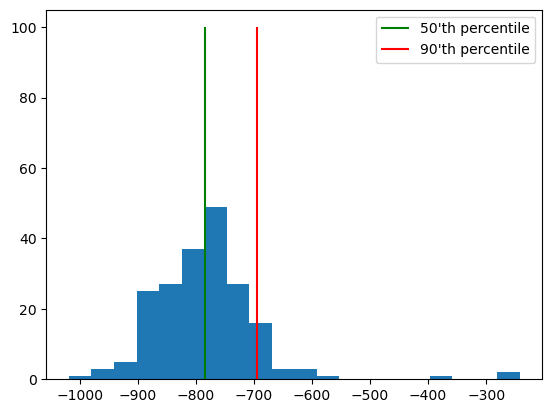

In [50]:
#let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()

### Crossentropy method steps (1pts)

In [81]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """ 
    reward_threshold = np.percentile(rewards_batch, percentile) #recalc threshold. hint : np.percentile
    
    elite_states = []
    elite_actions = []
    
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.append(states_batch[i])
            elite_actions.append(actions_batch[i])
    
    if(len(np.array(elite_states[0]).shape) == 1):
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)
    elite_actions = np.hstack(elite_actions)
    
    return elite_states,elite_actions
    

In [82]:
states_batch = [
    [1,2,3],   #game1
    [4,2,0,2], #game2
    [3,1]      #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = np.array([
    3,         #game1
    4,         #game2
    5,         #game3
])

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [83]:
def update_policy(elite_states,elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to
    
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    
    new_policy = np.zeros([n_states,n_actions])
    
    #<Your code here: update probabilities for actions given elite states & actions>
    #Don't forget to set 1/n_actions for all actions in unvisited states.
    
    for state, action in zip(elite_states, elite_actions):
        state_index = state
        action_index = action
        new_policy[state_index, action_index] += 1

    for state_index in range(n_states):
        total_count = np.sum(new_policy[state_index])
        if total_count > 0:
            new_policy[state_index] = new_policy[state_index] / total_count
        else:
            new_policy[state_index] = np.ones(n_actions, dtype='float64') / n_actions
    
    return new_policy

In [84]:

elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
print(new_policy[:4,:5])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

[[1.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         0.         0.5        0.5       ]]
Ok!


# Training loop (1pts)
Generate sessions, select N best and fit to those.

In [85]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def show_progress(rewards_batch,log,perc, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,perc)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [86]:
#reset policy just in case
policy = np.zeros((n_states, n_actions)) + float(1) / n_actions

mean reward = -288.804, threshold=8.000


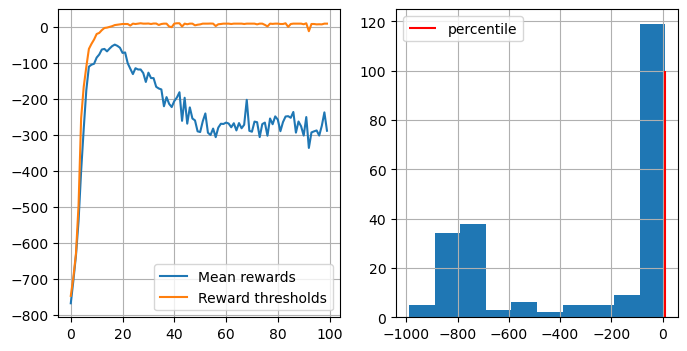

In [57]:
n_sessions = 250  #sample this many sessions
percentile = 70  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []

for i in range(100):
    %time sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,np.array(rewards_batch),percentile=percentile)
    
    new_policy = update_policy(elite_states,elite_actions)
    policy = (1 - learning_rate) * policy + learning_rate * new_policy
    
    #display results on chart
    show_progress(rewards_batch,log,percentile)

# Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples. Show all precentiles on one graph and all n_samples on another
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [87]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v2")
env.reset()
n_states = env.observation_space.n
n_actions = env.action_space.n
policy = 1/6. * np.ones([n_states, n_actions])
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float64]
policy = np.ones([n_states,n_actions])/n_actions 
stepCounter = 100

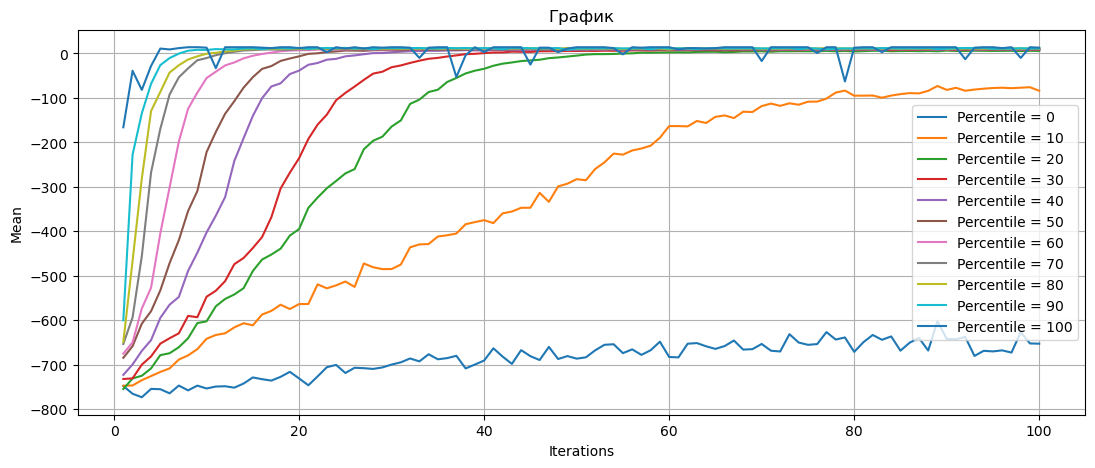

In [59]:
n_sessions = 250  #sample this many sessions
percentiles = [i for i in range(0, 101, 10)]  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []
mean = []
for percentile in percentiles:
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions
    for i in range(stepCounter):

        %time sessions = [generate_session(policy) for _ in range(n_sessions)]
        
        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch,actions_batch,np.array(rewards_batch),percentile=percentile)

        new_policy = update_policy(elite_states,elite_actions)
        policy = (1 - learning_rate) * policy + learning_rate * new_policy
        
        rewards_batch = np.array(rewards_batch)
        curMean.append(np.mean(rewards_batch[rewards_batch >= np.percentile(rewards_batch, percentile)]))
        
        clear_output(True)
    mean.append(curMean)
    #display results on chart
    #show_progress(rewards_batch,log)

f, (ax) = plt.subplots(1, 1, figsize=(13, 5))
for i in range(len(mean)):
    ax.plot(np.arange(stepCounter) + 1, np.array(mean[i]), label="Percentile = "+str(percentiles[i]))
ax.set_title(u"График")
ax.set_xlabel(u"Iterations")
ax.set_ylabel(u"Mean")
ax.grid()
ax.legend()

# How do different percentiles affect training efficiency?

Именно здесь чем больше процент, тем больше средняя награда, но выглядит как парабола, нужно каждый раз подбирать заново процент.

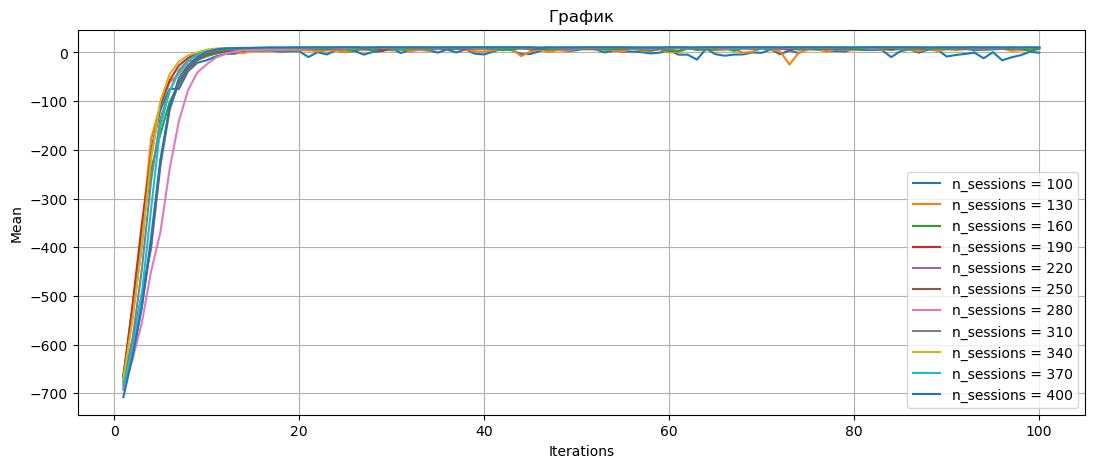

In [88]:
n_sessions_ar = [i for i in range(100, 401, 30)]  #sample this many sessions
perc = 60  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []
mean = []
for n_sessions in n_sessions_ar:
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions
    for i in range(stepCounter):

        %time sessions = [generate_session(policy) for _ in range(n_sessions)]
        
        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch,actions_batch,np.array(rewards_batch),percentile=perc)

        new_policy = update_policy(elite_states,elite_actions)
        
        rewards_batch = np.array(rewards_batch)
    
        policy = update_policy(elite_states,elite_actions)
        
        curMean.append(np.mean(rewards_batch[rewards_batch >= np.percentile(rewards_batch, perc)]))
        
        clear_output(True)
    mean.append(curMean)
    #display results on chart
    #show_progress(rewards_batch,log)


f, (ax) = plt.subplots(1, 1, figsize=(13, 5))
for i in range(len(mean)):
    ax.plot(np.arange(stepCounter) + 1, np.array(mean[i]), label="n_sessions = "+str(n_sessions_ar[i]))
ax.set_title(u"График")
ax.set_xlabel(u"Iterations")
ax.set_ylabel(u"Mean")
ax.grid()
ax.legend()

# Stabilize positive rewards by averaging policy across 10 games (2 pts)

In [90]:
def generate_session(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    cnt_games = 10
    
    for _ in range(cnt_games):
        reward = 0.
        
        s = env.reset()

        for t in range(t_max):
            a = np.random.choice(range(n_actions), p = policy[s])

            now = env.step(a)
            new_s,r,done = now[0], now[1], now[2]

            #Record state, action and add up reward to states,actions and total_reward accordingly. 
            states.append(s)
            actions.append(a)
            reward += r

            s = new_s
            if done:
                break
        total_reward += reward
    total_reward /= cnt_games
    
    return states,actions,total_reward
        


mean reward = 5.084, threshold=6.160


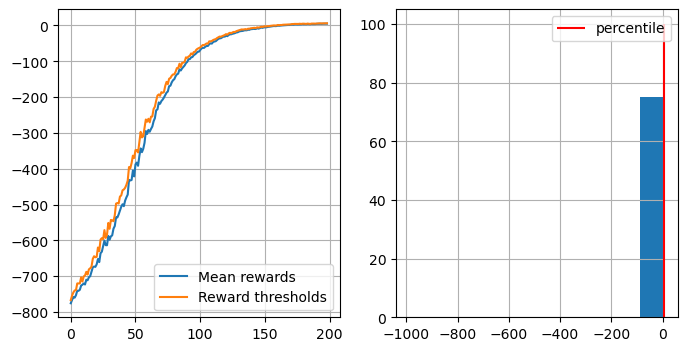

win!


In [91]:
n_sessions = 75  #sample this many sessions
percentile = 70  #take this percent of session with highest rewards
learning_rate = 0.2  #add this thing to all counts for stability

log = []
mean = []
policy = np.ones([n_states,n_actions])/n_actions
for i in range(1000):

    %time sessions = [generate_session(policy) for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,np.array(rewards_batch),percentile=50)

    new_policy = update_policy(elite_states,elite_actions)
    policy = (1 - learning_rate) * policy + learning_rate * new_policy

    show_progress(rewards_batch,log,percentile)
    
    rewards_batch = np.array(rewards_batch)
    if(np.mean(rewards_batch[rewards_batch >= np.percentile(rewards_batch, percentile)]) > 7):
        print("win!")
        break

# Digging deeper: approximate crossentropy with neural nets (2 pts)

In this section we will train a neural network policy for continuous state space game

In [93]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make("CartPole-v0").env  #if you see "<classname> has no attribute .env", remove .env or update gym

env.reset()
n_actions = 2

env.render()

NameError: name 'base' is not defined

In this case use NN as a black box. All your should know that it is more complex than a tabular method. 

In [94]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )

In [95]:
def generate_session(t_max=1000):
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        try:
            probs = agent.predict_proba([s.tolist()])[0]
        except Exception:
            probs = [1. / n_actions for i in range(n_actions)]
        
        a = np.random.choice(np.arange(n_actions), p=probs)
        
        now = env.step(a)
        new_s,r,done = now[0], now[1], now[2]
        
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done: 
            break
    return states,actions,total_reward
        

In [96]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """ 
    reward_threshold = np.percentile(rewards_batch, percentile) #recalc threshold. hint : np.percentile
    
    elite_states = []
    elite_actions = []
    
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.append(states_batch[i])
            elite_actions.append(actions_batch[i])
    
    if(len(np.array(elite_states[0]).shape) == 1):
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)
    elite_actions = np.hstack(elite_actions)
    
    return elite_states,elite_actions

To train this classification model use fit(states, actions). In this case we are training classificator to predict the correct class (action) in a given state

In [97]:
n_sessions = 100
percentile = 70
log = []

def get(x):
    k = x
    return k.reshape(-1, 1)

for i in range(100):
    sessions = [generate_session() for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile=percentile)
    
    #elite_states = elite_states.reshape(-1, 1)
    
    
    agent.fit(get(elite_states), elite_actions)

    show_progress(rewards_batch,log,percentile)
    
    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

ValueError: Found input variables with inconsistent numbers of samples: [4560, 1140]

# Report (1 pts)

С помощью изменения процента элит, количества сессий и скорости обучения можно добиваться сильно различных результатов. (нужно и избежать переобучения и чтобы было достаточно много)
Лучшая комбинация, которую я нашел для Taxi, в ее поле записана.
Нужно одновременно не ставить слишком большие и слишком маленькие параметры для достижения хороших результатов.
В конце попробовал использовать нейронную сеть как черный ящик, учится очень быстро и с первого раза хорошо.

In [ ]:
С помощью изменения процента элит, количества сессий и скорости обучения можно
добиваться сильно различных результатов. (нужно и избежать переобучения и чтобы
было достаточно много) Лучшая комбинация, которую я нашел для Taxi, в ее поле
записана. Нужно одновременно не ставить слишком большие и слишком маленькие
параметры для достижения хороших результатов. В конце попробовал использовать 
нейронную сеть как черный ящик, учится очень быстро и с первого раза хорошо.


Работу делал вместе с Антоном Ныйкиным и Иваном Осокиным, т.к. материал был
сложный для меня и оставалось не так много времени. Они мне очень сильно
помогли, спасибо огромное им за это!!